In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
"""
Let's recap:

We got some data and created a trading rule
"""
from sysdata.csvdata import csvFuturesData
data = csvFuturesData()

from systems.provided.example.rules import ewmac_forecast_with_defaults as ewmac

"""
Okay, I wonder how this would work for a number of instruments?

For this we need to build a system

A system is made up of SystemStages - essentially stages in the process, and it needs data, and perhaps a configuration

The minimum stage you would have would be Rules - which is where you put trading rules
"""

from systems.forecasting import Rules

"""
We can create rules in a number of different ways

Note that to make our rule work it needs to have
"""
my_rules = Rules(ewmac)
print(my_rules.trading_rules())

my_rules = Rules(dict(ewmac=ewmac))
print(my_rules.trading_rules())

from systems.basesystem import System
my_system = System([my_rules], data)
print(my_system)

print(my_system.rules.get_raw_forecast("EDOLLAR", "ewmac").tail(5))

{'rule0': TradingRule; function: <function ewmac_forecast_with_defaults at 0x7f7fa3c9f8c8>, data:  and other_args: }
{'ewmac': TradingRule; function: <function ewmac_forecast_with_defaults at 0x7f7fa3c9f8c8>, data:  and other_args: }
System with stages: rules
                        ewmac
2015-12-11 12:00:25  0.241975
2015-12-11 14:11:34  0.292945
2015-12-11 15:39:37  0.339199
2015-12-11 17:08:14  0.422408
2015-12-11 19:33:39  0.542370


In [3]:
"""
Define a TradingRule
"""

from systems.forecasting import TradingRule
ewmac_rule = TradingRule(ewmac)
my_rules = Rules(dict(ewmac=ewmac_rule))
ewmac_rule


"""
... or two...
"""

# pass rules into System
ewmac_8 = TradingRule((ewmac, [], dict(Lfast=8, Lslow=32)))
ewmac_32 = TradingRule(dict(function=ewmac, other_args=dict(Lfast=32, Lslow=128)))

my_rules = Rules(dict(ewmac8=ewmac_8, ewmac32=ewmac_32))
print(my_rules.trading_rules()['ewmac32'])

my_system = System([my_rules], data)
my_system.rules.get_raw_forecast("EDOLLAR", "ewmac32").tail(5)

TradingRule; function: <function ewmac_forecast_with_defaults at 0x7f7fa3c9f8c8>, data:  and other_args: Lfast, Lslow


,ewmac32
2015-12-11 12:00:25,0.241975
2015-12-11 14:11:34,0.292945
2015-12-11 15:39:37,0.339199
2015-12-11 17:08:14,0.422408
2015-12-11 19:33:39,0.542370


In [4]:
# populate Rules from Config
from sysdata.configdata import Config
my_config = Config()

empty_rules = Rules()
my_config.trading_rules = dict(ewmac8=ewmac_8, ewmac32=ewmac_32)
my_system = System([empty_rules], data, my_config)
my_system.rules.get_raw_forecast("EDOLLAR", "ewmac32").tail(5)

,ewmac32
2015-12-11 12:00:25,0.241975
2015-12-11 14:11:34,0.292945
2015-12-11 15:39:37,0.339199
2015-12-11 17:08:14,0.422408
2015-12-11 19:33:39,0.542370


In [5]:
from systems.forecast_scale_cap import ForecastScaleCapFixed

my_config.forecast_scalars = dict(ewmac8=5.3, ewmac32=2.65)
fcs = ForecastScaleCapFixed()
my_system = System([fcs, my_rules], data, my_config)
my_system.forecastScaleCap.get_capped_forecast(
    "EDOLLAR", "ewmac32").tail(5)

,ewmac32
2015-12-11 12:00:25,0.641233
2015-12-11 14:11:34,0.776304
2015-12-11 15:39:37,0.898877
2015-12-11 17:08:14,1.119382
2015-12-11 19:33:39,1.437280


In [6]:
"""
combine some rules
"""
from systems.forecast_combine import ForecastCombineFixed

# forecast_weights=dict(ewmac8=0.5, ewmac32=0.5), forecast_div_multiplier=1.1
combiner = ForecastCombineFixed()
my_system = System([fcs, my_rules, combiner], data, my_config)
my_system.combForecast.get_combined_forecast("EDOLLAR").tail(5)

,comb_forecast
2015-12-11 12:00:25,-0.176179
2015-12-11 14:11:34,0.636608
2015-12-11 15:39:37,1.067901
2015-12-11 17:08:14,1.872139
2015-12-11 19:33:39,2.897389


In [7]:
my_config.forecast_weights = dict(ewmac8=0.5, ewmac32=0.5)
my_config.forecast_div_multiplier = 1.1
my_system = System([fcs, empty_rules, combiner], data, my_config)
my_system.combForecast.get_combined_forecast("EDOLLAR").tail(5)

# size positions
from systems.positionsizing import PositionSizing
possizer = PositionSizing()
my_config.percentage_vol_target = 25
my_config.notional_trading_capital = 500000
my_config.base_currency = "GBP"

my_system = System([fcs, my_rules, combiner, possizer], data, my_config)

my_system.positionSize.get_price_volatility("EDOLLAR").tail(5)

,vol
2015-12-07,0.057630
2015-12-08,0.056030
2015-12-09,0.054418
2015-12-10,0.055318
2015-12-11,0.059724


In [8]:
my_system.positionSize.get_block_value("EDOLLAR").tail(5)

,bvalue
2015-12-07,2448.0000
2015-12-08,2448.3750
2015-12-09,2448.6250
2015-12-10,2447.0000
2015-12-11,2449.6875


In [9]:
my_system.positionSize.get_instrument_sizing_data("EDOLLAR")[0].tail(5)

,price
2015-12-07,97.9200
2015-12-08,97.9350
2015-12-09,97.9450
2015-12-10,97.8800
2015-12-11,97.9875


In [10]:
my_system.positionSize.get_instrument_value_vol("EDOLLAR").tail(5)

,ivv
2015-12-04,94.981647
2015-12-07,93.445111
2015-12-08,91.178750
2015-12-09,88.519571
2015-12-10,89.441887


In [11]:
my_system.positionSize.get_volatility_scalar("EDOLLAR").tail(5)

,vol_scalar
2015-12-04,82.252733
2015-12-07,83.605230
2015-12-08,85.683342
2015-12-09,88.257319
2015-12-10,87.347218


In [12]:
my_system.positionSize.get_daily_cash_vol_target()

{'annual_cash_vol_target': 125000.0,
 'base_currency': 'GBP',
 'daily_cash_vol_target': 7812.5,
 'notional_trading_capital': 500000.0,
 'percentage_vol_target': 25}

In [13]:
my_system.positionSize.get_subsystem_position("EDOLLAR").tail(5)

,ss_position
2013-09-25,0.784995
2013-09-26,5.005528
2013-09-27,10.318398
2013-09-30,14.980339
2013-10-01,16.225480


In [14]:
# portfolio
from systems.portfolio import PortfoliosFixed
portfolio = PortfoliosFixed()

my_config.instrument_weights = dict(US10=.1, EDOLLAR=.4, CORN=.3, SP500=.2)
my_config.instrument_div_multiplier = 1.5

my_system = System([fcs, my_rules, combiner, possizer,
                    portfolio], data, my_config)

my_system.portfolio.get_notional_position("EDOLLAR").tail(5)

,pos
2013-09-25,0.470997
2013-09-26,3.003317
2013-09-27,6.191039
2013-09-30,8.988203
2013-10-01,9.735288


In [15]:
"""
Have we made some dosh?
"""

from systems.account import Account
my_account = Account()
my_system = System([fcs, my_rules, combiner, possizer,
                    portfolio, my_account], data, my_config)
profits = my_system.accounts.portfolio()
profits.stats()

[[('min', '-0.1851'),
  ('max', '0.2097'),
  ('median', '0'),
  ('mean', '0.0006869'),
  ('std', '0.01854'),
  ('skew', '-0.1128'),
  ('ann_daily_mean', '0.1759'),
  ('ann_daily_std', '0.2966'),
  ('sharpe', '0.5929'),
  ('sortino', '0.6696'),
  ('avg_drawdown', '-0.1234'),
  ('time_in_drawdown', '0.9735'),
  ('calmar', '0.2871'),
  ('avg_return_to_drawdown', '1.425'),
  ('avg_loss', '-0.01302'),
  ('avg_gain', '0.0131'),
  ('gaintolossratio', '1.006'),
  ('profitfactor', '1.138'),
  ('hitrate', '0.5308')],
 ('You can also plot:', ['rolling_ann_std', 'drawdown', 'curve']),
 ('You can also print:', ['weekly', 'monthly', 'annual'])]

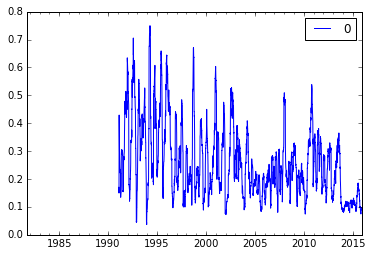

In [16]:
profits.rolling_ann_std().plot()

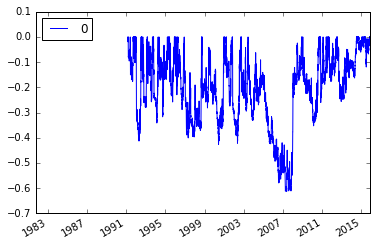

In [17]:
profits.drawdown().plot()

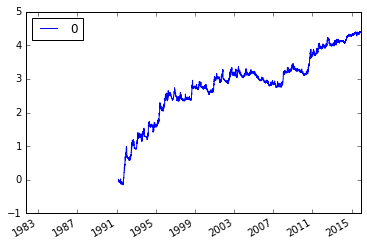

In [18]:
profits.curve().plot()

In [20]:
"""
Another approach is to create a config object
"""
my_config = Config(dict(trading_rules=dict(ewmac8=ewmac_8, ewmac32=ewmac_32),
                        instrument_weights=dict(
                            US10=.1, EDOLLAR=.4, CORN=.3, SP500=.2),
                        instrument_div_multiplier=1.5, forecast_scalars=dict(ewmac8=5.3, ewmac32=2.65),
                        forecast_weights=dict(ewmac8=0.5, ewmac32=0.5), forecast_div_multiplier=1.1,
                        percentage_vol_target=25.00, notional_trading_capital=500000, base_currency="GBP"))
print(my_config)
my_system = System([Account(), PortfoliosFixed(), PositionSizing(), ForecastCombineFixed(), ForecastScaleCapFixed(), Rules()
                    ], data, my_config)
print(my_system.portfolio.get_notional_position("EDOLLAR").tail(5))

"""
... or to import one
"""
my_config = Config("systems.provided.example.simplesystemconfig.yaml")
print(my_config)
my_system = System([Account(), PortfoliosFixed(), PositionSizing(), ForecastCombineFixed(), ForecastScaleCapFixed(), Rules()
                    ], data, my_config)
print(my_system.rules.get_raw_forecast("EDOLLAR", "ewmac32").tail(5))
print(my_system.rules.get_raw_forecast("EDOLLAR", "ewmac8").tail(5))
print(my_system.forecastScaleCap.get_capped_forecast(
    "EDOLLAR", "ewmac32").tail(5))
print(my_system.forecastScaleCap.get_forecast_scalar("EDOLLAR", "ewmac32"))
print(my_system.combForecast.get_combined_forecast("EDOLLAR").tail(5))
print(my_system.combForecast.get_forecast_weights("EDOLLAR").tail(5))

print(my_system.positionSize.get_subsystem_position("EDOLLAR").tail(5))

print(my_system.portfolio.get_notional_position("EDOLLAR").tail(5))

Config with elements: base_currency, forecast_div_multiplier, forecast_scalars, forecast_weights, instrument_div_multiplier, instrument_weights, notional_trading_capital, percentage_vol_target, trading_rules
                 pos
2013-09-25  0.470997
2013-09-26  3.003317
2013-09-27  6.191039
2013-09-30  8.988203
2013-10-01  9.735288
Config with elements: base_currency, forecast_div_multiplier, forecast_weights, instrument_div_multiplier, instrument_weights, notional_trading_capital, percentage_vol_target, trading_rules
                      ewmac32
2015-12-11 12:00:25  0.241975
2015-12-11 14:11:34  0.292945
2015-12-11 15:39:37  0.339199
2015-12-11 17:08:14  0.422408
2015-12-11 19:33:39  0.542370
                       ewmac8
2015-12-11 12:00:25 -0.187470
2015-12-11 14:11:34  0.093757
2015-12-11 15:39:37  0.233382
2015-12-11 17:08:14  0.495263
2015-12-11 19:33:39  0.822169
                      ewmac32
2015-12-11 12:00:25  0.641233
2015-12-11 14:11:34  0.776304
2015-12-11 15:39:37  0.898